# TUDelft usecase 2A

Frequent tests of imaging modalities are a common way to test if an imaging modality is functioning as expected. The main problem is that access to imaging modalities is limited and performing tests is often considered by the technologists to be a difficult and complex exercise. As a result the amount of available data is limited. 
On the other hand imaging modalities continuously generate data with each patient exam. 

In this case we investigate the properties of clinical CT scans. 
Can you quantify the effects of additional parameters of interest such as patient size, patient weight, certain acquisition parameters on the results?


# The CT data

With each scan we also have a set of metadata that tells us various things about the scan such as the radiation dose estimate to the patient. The scan data is in DICOM format which contains both the images as well as the meta information.

The data consists of roughly 50 CT scans acquired in a 7 week period from our Siemens Flash scanner.

# Question for this case:

<li><b> Which (of the known and available) factors influence patient dose and in what way? </b></li>

<li><b> What is the effect of patient size / volume on patient dose? </b></li>

<li><b> If we correct for known factors what is the remaining variation in patient dose? </b></li>

<li><b> Can you determine patient independent (noise) characteristics in the CT series? </b></li>


In [1]:
# To import the data we need the dicom library
import os
import numpy as np
from matplotlib import pyplot as plt

The following code shows how to read the files in a DICOMDIR and output fileproperties such as studyid, patientname, number of files etc.

In [2]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

# fetch the path to the test data
#filepath = get_testdata_files('DICOMDIR')[0]
#print('Path to the DICOM directory: {}'.format(filepath))
# load the data

def _getstudies(filepath):
    filepath = filepath 
    dicom_dir = read_dicomdir(filepath)
    base_dir = dirname(filepath)

    allstudies = {}

    # go through the patient record and print information
    for patient_record in dicom_dir.patient_records:
        if (hasattr(patient_record, 'PatientID') and
                hasattr(patient_record, 'PatientName')):
            print("Patient: {}: {}".format(patient_record.PatientID,
                                           patient_record.PatientName))
        studies = patient_record.children
        # got through each serie
        for study in studies:
            print(" " * 4 + "Study {}: {}: {}".format(study.StudyID,
                                                      study.StudyDate,
                                                      study.StudyDescription))
            allstudies[study.StudyID] = []
            all_series = study.children
            # go through each serie
            tmpseries = {}
            for series in all_series:
                image_count = len(series.children)
                plural = ('', 's')[image_count > 1]

                # Write basic series info and image count

                # Put N/A in if no Series Description
                if 'SeriesDescription' not in series:
                    series.SeriesDescription = "N/A"
                print(" " * 8 + "Series {}: {}: {} ({} image{})".format(
                    series.SeriesNumber, series.Modality, series.SeriesDescription,
                    image_count, plural))

                # Open and read something from each image, for demonstration
                # purposes. For simple quick overview of DICOMDIR, leave the
                # following out
                print(" " * 12 + "Reading images...")
                image_records = series.children
                image_filenames = [join(base_dir, *image_rec.ReferencedFileID)
                                   for image_rec in image_records]

                datasets = [pydicom.dcmread(image_filename)
                            for image_filename in image_filenames]

                patient_names = set(ds.PatientName for ds in datasets)
                patient_IDs = set(ds.PatientID for ds in datasets)

                # List the image filenames
                print("\n" + " " * 12 + "Image filenames:")
                print(" " * 12, end=' ')
                pprint(image_filenames, indent=12)

                # Expect all images to have same patient name, id
                # Show the set of all names, IDs found (should each have one)
                print(" " * 12 + "Patient Names in images..: {}".format(
                    patient_names))
                print(" " * 12 + "Patient IDs in images..: {}".format(
                    patient_IDs))
                tmpseries[int(series.SeriesNumber)] = datasets

            allstudies[study.StudyID].append(tmpseries)
    return allstudies

The above code loads a dicom directory and the results are stored in a dictionary object that contains for each study a list of series and each series contains a list of dataset objects. An individual dataset corresponds to an individual slice of the 3D CT scan

In [44]:
# These are the dicom studies in the dicomdir
allstudies = _getstudies("Thorax_Abdomen/week1/DICOMDIR")
print(allstudies.keys())

Patient: ANON864M5E16Q: Anonymous Female 1934
    Study E864M5E16Q: 20181017: CT Thorax/Abdomen
        Series 1: CT: ThorAbd  5.0  I40f  3 (128 images)
            Reading images...

            Image filenames:
             [           'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EED9D21E',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE28D880',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE0D01B4',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EEF91F10',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE92D375',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EEFBB3D1',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE16248D',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE415A37',
            'Thorax_Abdomen/we

In [40]:
# This example shows there is a series with index number 8 in the study which has 129 slices
print(len(allstudies['E864M5E18Q'][0][9]))

128


In [43]:
# This shows all the available tags of a specific slice
allstudies['E864M5E14Q'][0][8][0]

KeyError: 'E864M5E14Q'

In [7]:
# We can ask specific tag values

print(allstudies['E864M5E14Q'][0][8][0].StudyDescription)
print(allstudies['E864M5E14Q'][0][8][0].SeriesDescription)

# The average dose estimate for the scan is given by the CTDIvol tag

print(allstudies['E864M5E14Q'][0][8][0].CTDIvol) #The value has units of mGy = m J/kg

#The following tags are a subselection of the tags that influence patient dose and image quality most:
''' 
(0018, 0060) KVP                                 DS: "100"
(0018, 1020) Software Version(s)                 LO: 'syngo CT VA48A'
(0018, 1130) Table Height                        DS: "181"
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1150) Exposure Time                       IS: "500"
(0018, 1151) X-Ray Tube Current                  IS: "212"
(0018, 1152) Exposure                            IS: "176"
(0018, 1160) Filter Type                         SH: 'WEDGE_3'
(0018, 1170) Generator Power                     IS: "19"
(0018, 1190) Focal Spot(s)                       DS: "1.2"
(0018, 1210) Convolution Kernel                  SH: ['I40f', '3']
(0018, 9306) Single Collimation Width            FD: 0.6
(0018, 9307) Total Collimation Width             FD: 38.4
(0018, 9309) Table Speed                         FD: 46.0
(0018, 9310) Table Feed per Rotation             FD: 23.0
(0018, 9311) Spiral Pitch Factor                 FD: 0.6
'''

CT Thorax/Abdomen
ThorAbd  5.0  I40f  3
7.27693723826087


' \n(0018, 0060) KVP                                 DS: "100"\n(0018, 1020) Software Version(s)                 LO: \'syngo CT VA48A\'\n(0018, 1130) Table Height                        DS: "181"\n(0018, 1140) Rotation Direction                  CS: \'CW\'\n(0018, 1150) Exposure Time                       IS: "500"\n(0018, 1151) X-Ray Tube Current                  IS: "212"\n(0018, 1152) Exposure                            IS: "176"\n(0018, 1160) Filter Type                         SH: \'WEDGE_3\'\n(0018, 1170) Generator Power                     IS: "19"\n(0018, 1190) Focal Spot(s)                       DS: "1.2"\n(0018, 1210) Convolution Kernel                  SH: [\'I40f\', \'3\']\n(0018, 9306) Single Collimation Width            FD: 0.6\n(0018, 9307) Total Collimation Width             FD: 38.4\n(0018, 9309) Table Speed                         FD: 46.0\n(0018, 9310) Table Feed per Rotation             FD: 23.0\n(0018, 9311) Spiral Pitch Factor                 FD: 0.6\n'

In [8]:
# This shows all the slices are sorted correctly by instancenumber
for j in range(len(allstudies['E864M5E14Q'][0][8])):
    print(allstudies['E864M5E14Q'][0][8][j].InstanceNumber)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


In [9]:
#Tag values can be accessed in the following ways:

print(allstudies['E864M5E14Q'][0][8][0].PatientName)
print(allstudies['E864M5E14Q'][0][8][0]["0x10","0x10"])
print(allstudies['E864M5E14Q'][0][8][0][pydicom.tag.Tag("0010","0010")])


Anonymous Male 1948
(0010, 0010) Patient's Name                      PN: 'Anonymous Male 1948'
(0010, 0010) Patient's Name                      PN: 'Anonymous Male 1948'


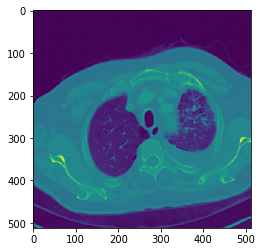

In [28]:
# The imagedata can be accessed through the pixel_array routine:

plt.imshow(allstudies['E864M5E14Q'][0][8][10].pixel_array)

In [11]:
# CT values, also called Houndsfield Units (HU) reflect the attenuation properties of different tissues and range from -1000 (air)
# up to 2000+ for bone: https://en.wikipedia.org/wiki/Hounsfield_scale
# To get the pixel values in terms of HU we need to apply an offset and rescale to the image

rawarray = allstudies['E864M5E14Q'][0][8][20].pixel_array
slope = allstudies['E864M5E14Q'][0][8][20].RescaleSlope
intercept = allstudies['E864M5E14Q'][0][8][20].RescaleIntercept
print ("Before rescaling:", rawarray.min())
rescaled = rawarray*slope + intercept
print ("After rescaling:", rescaled.min()) 


    

Before rescaling: 0
After rescaling: -1024.0


In [12]:
from scipy import ndimage

(-0.5, 511.5, 511.5, -0.5)

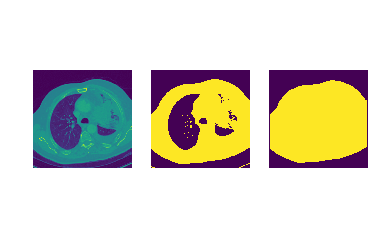

In [13]:
# It might be interesting to add the size of the patient as a variable
# A very simple way to determine this would be to threshold the image and count the number of pixels for each slice

tmparr = allstudies['E864M5E12Q'][0][8][20].pixel_array

tmpmask = tmparr > 800


fig, ax = plt.subplots()


plt.axis('off')
ax = fig.add_subplot(1,3,1)
ax = plt.imshow(tmparr)
plt.axis('off')


ax = fig.add_subplot(1,3,2)
ax = plt.imshow(tmpmask)
plt.axis('off')


closedmask = ndimage.binary_erosion(tmpmask,iterations =6)
closedmask = ndimage.binary_fill_holes(closedmask)


ax = fig.add_subplot(1,3,3)
ax = plt.imshow(closedmask)
plt.axis('off')

In [14]:
# A good overview of some simple out-of-the-box available image manipulation techniques can be found at
# http://scipy-lectures.org/advanced/image_processing/

from skimage import measure


In [15]:
perimeter = measure.perimeter(closedmask)
area = np.count_nonzero(closedmask)
#We can also determine the average HU of the patient
meanhu = np.mean(tmparr[closedmask])

print("Area:", area, " - Perimeter", perimeter, "- Mean HU", meanhu )


Area: 178393  - Perimeter 1616.5138520739843 - Mean HU 869.6159098170892


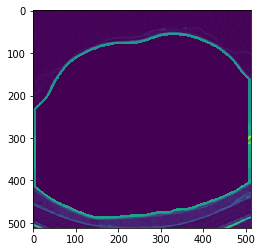

In [16]:
#We can also determine the average HU of the patient
newimage = np.zeros(tmparr.shape)
newimage[~closedmask] = tmparr[~closedmask]
plt.imshow(newimage)

# Example: Simple timeseries plot of dose

In [18]:
basedir = "Thorax_Abdomen/"
ctdatadir = os.listdir(basedir)

In [19]:
doseoverview = {}

for tmpdata in ctdatadir:
    weekstudies = _getstudies(os.path.join(basedir,tmpdata,"DICOMDIR"))
    for key in weekstudies.keys():
        tmpstudy = weekstudies[key][0]
        if len(tmpstudy.keys()) > 1:
            print ("More than 1 study for this patient!")
            break
            
        seriesid = list(tmpstudy.keys())
        print(seriesid)
        seriesid = seriesid[0]
        doseoverview[key] = tmpstudy[seriesid][0].CTDIvol

Patient: ANON864M5E16Q: Anonymous Female 1934
    Study E864M5E16Q: 20181017: CT Thorax/Abdomen
        Series 1: CT: ThorAbd  5.0  I40f  3 (128 images)
            Reading images...

            Image filenames:
             [           'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EED9D21E',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE28D880',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE0D01B4',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EEF91F10',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE92D375',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EEFBB3D1',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE16248D',
            'Thorax_Abdomen/week1\\DICOM\\000004E1\\AA67D814\\AA417B20\\00006A1B\\EE415A37',
            'Thorax_Abdomen/we

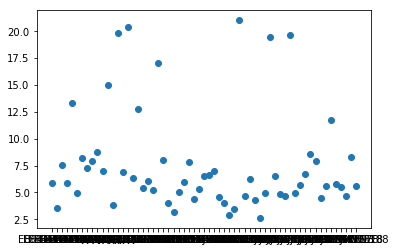

In [20]:
plt.scatter(x = doseoverview.keys(),y = doseoverview.values())